In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
project_dir = '/content/drive/My Drive/ssm_ehr'
print(os.path.exists(project_dir))

Mounted at /content/drive
True


In [ ]:

print(os.getcwd())

/content


In [ ]:
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu121
!pip uninstall mamba-ssm causal-conv1d
!pip install causal-conv1d && pip install mamba-ssm

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.1/799.1 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 855.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from mamba_ssm import Mamba  # Assuming Mamba is installed
import math
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/triton/layer_norm.py:1045: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type=

In [ ]:
from sklearn.metrics import average_precision_score

In [ ]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0).to(device)  # Shape: (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]  # Add positional encoding


class MambaAttentionClassifier(nn.Module):
    def __init__(self, ts_feature_dim, static_feature_dim, hidden_dim, num_classes):
        """
        Args:
            ts_feature_dim (int): Number of features in time-series data (e.g., 37).
            static_feature_dim (int): Number of features in static data (e.g., 8).
            hidden_dim (int): Dimension of hidden states in the model.
            num_classes (int): Number of output classes (e.g., 2 for binary classification).
        """
        super(MambaAttentionClassifier, self).__init__()

        # Time-series processing with Mamba
        self.positional_encoding = PositionalEncoding(d_model=ts_feature_dim)
        self.mamba_layer = Mamba(
            d_model=ts_feature_dim,  # Include time as an additional feature
            d_state=hidden_dim,         # Mamba's internal state size
            d_conv=4,                   # Convolution width for local dependencies
            expand=2                    # Expansion factor
        )

        self.projection = nn.Linear(ts_feature_dim, hidden_dim)
        self.mamba_norm = nn.LayerNorm(hidden_dim)  # Layer normalization for stability


        # Multi-head attention
        self.multihead_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)

        # Static feature processing
        self.static_fc = nn.Linear(static_feature_dim, hidden_dim)
        self.static_norm = nn.LayerNorm(hidden_dim)

        # Fully connected layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, ts_values, ts_indicators, ts_time, static):
        """
        Args:
            ts_values (torch.Tensor): Time-series data (batch_size, seq_len, ts_feature_dim).
            ts_indicators (torch.Tensor): Indicator for missing time-series data (batch_size, seq_len, ts_feature_dim).
            ts_time (torch.Tensor): Time-series timestamps (batch_size, seq_len).
            static (torch.Tensor): Static features (batch_size, static_feature_dim).
        Returns:
            torch.Tensor: Class probabilities (batch_size, num_classes).
        """
        # Ensure the shape of ts_indicators matches ts_values
        assert ts_values.shape == ts_indicators.shape, "Shape mismatch between ts_values and ts_indicators"

        # Handle missing data: Mask out the missing time-series values using ts_indicators
        ts_values = ts_values * ts_indicators  # Element-wise multiplication to mask missing data

        # Add time as an additional feature and apply positional encoding
        ts_time = ts_time.unsqueeze(-1)  # (batch_size, seq_len, 1)
        ts_combined = torch.cat([ts_values, ts_time], dim=-1)  # (batch_size, seq_len, ts_feature_dim + 1)
        ts_combined = self.positional_encoding(ts_combined)

        # Process time-series data with Mamba
        ts_encoded = self.mamba_layer(ts_combined)  # (batch_size, seq_len, hidden_dim)
        ts_encoded = self.projection(ts_encoded)  # (batch_size, seq_len, hidden_dim)
        ts_encoded = self.mamba_norm(ts_encoded)  # Normalize the Mamba output


        # Apply multi-head attention
        ts_encoded, _ = self.multihead_attention(ts_encoded, ts_encoded, ts_encoded)

        # Compute attention weights
        attn_weights = F.softmax(torch.mean(ts_encoded, dim=-1, keepdim=True), dim=1)  # (batch_size, seq_len, 1)
        ts_attended = torch.sum(attn_weights * ts_encoded, dim=1)  # (batch_size, hidden_dim)

        # Process static features
        static_encoded = F.relu(self.static_fc(static))  # (batch_size, hidden_dim)
        static_encoded = self.static_norm(static_encoded)

        # Concatenate attended time-series and static features
        combined = torch.cat([ts_attended, static_encoded], dim=1)  # (batch_size, hidden_dim * 2)

        # Classification
        output = self.classifier(combined)  # (batch_size, num_classes)

        return output


In [ ]:

class MambaAttentionClassifier(nn.Module):
    def __init__(self, ts_feature_dim, static_feature_dim, hidden_dim, num_classes):
        """
        Args:
            ts_feature_dim (int): Number of features in time-series data (e.g., 37).
            static_feature_dim (int): Number of features in static data (e.g., 8).
            hidden_dim (int): Dimension of hidden states in the model.
            num_classes (int): Number of output classes (e.g., 2 for binary classification).
        """
        super(MambaAttentionClassifier, self).__init__()

        # Time-series processing with Mamba
        self.mamba_layer = Mamba(
            d_model=ts_feature_dim,  # Include time as an additional feature
            d_state=hidden_dim,         # Mamba's internal state size
            d_conv=4,                   # Convolution width for local dependencies
            expand=2                    # Expansion factor
        )

        # Static feature processing
        self.static_fc = nn.Linear(static_feature_dim, hidden_dim)

        # Attention layer to weight time-series features
        self.attention = nn.Linear(ts_feature_dim, 1)

        # Fully connected layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(ts_feature_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, ts_values, ts_indicators, ts_time, static):
      """
      Args:
          ts_values (torch.Tensor): Time-series data (batch_size, seq_len, ts_feature_dim).
          ts_indicators (torch.Tensor): Indicator for missing time-series data (batch_size, seq_len, ts_feature_dim).
          ts_time (torch.Tensor): Time-series timestamps (batch_size, seq_len).
          static (torch.Tensor): Static features (batch_size, static_feature_dim).
      Returns:
          torch.Tensor: Class probabilities (batch_size, num_classes).
      """
      # Ensure the shape of ts_indicators matches ts_values
      assert ts_values.shape == ts_indicators.shape, "Shape mismatch between ts_values and ts_indicators"

      # Handle missing data: Mask out the missing time-series values using ts_indicators
      ts_values = ts_values * ts_indicators  # Element-wise multiplication to mask missing data

      ts_time = ts_time.unsqueeze(-1)  # (batch_size, seq_len, 1)
      ts_combined = torch.cat([ts_values, ts_time], dim=-1)  # (batch_size, seq_len, ts_feature_dim + 1)

      # Process time-series data with Mamba
      ts_encoded = self.mamba_layer(ts_combined)  # (batch_size, seq_len, hidden_dim)

      # print('ts_encoded shape',ts_encoded.shape)

      # Reshape ts_encoded for the attention layer
      batch_size, seq_len, hidden_dim = ts_encoded.shape
      ts_encoded_flat = ts_encoded.view(-1, hidden_dim)  # Flatten to (batch_size * seq_len, hidden_dim)

      # Compute attention scores
      attn_scores = self.attention(ts_encoded_flat)  # (batch_size * seq_len, 1)
      attn_scores = attn_scores.view(batch_size, seq_len, 1)  # Reshape back to (batch_size, seq_len, 1)

      # Compute attention weights
      attn_weights = F.softmax(attn_scores, dim=1)  # (batch_size, seq_len, 1)

      # Apply attention weights to the Mamba output
      ts_attended = torch.sum(attn_weights * ts_encoded, dim=1)  # (batch_size, hidden_dim)

      # Process static features
      static_encoded = F.relu(self.static_fc(static))  # (batch_size, hidden_dim)

      # Concatenate attended time-series and static features
      combined = torch.cat([ts_attended, static_encoded], dim=1)  # (batch_size, hidden_dim * 2)

      # print('ts_attended shape',ts_attended.shape)
      # print('static_encoded shape', static_encoded.shape)
      # print('combined shape', combined.shape)

      # Classification
      output = self.classifier(combined)  # (batch_size, num_classes)

      return output



In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Compute sine and cosine values separately
        pe[:, 0::2] = torch.sin(position * div_term[: (d_model + 1) // 2])  # Handle odd d_model for sine
        pe[:, 1::2] = torch.cos(position * div_term[: d_model // 2])  # Handle odd d_model for cosine

        self.pe = pe.unsqueeze(0).to(device)  # Shape: (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]  # Add positional encoding


class MambaAttentionClassifier(nn.Module):
    def __init__(self, ts_feature_dim, static_feature_dim, hidden_dim, num_classes, max_time_steps=1000):
        """
        Args:
            ts_feature_dim (int): Number of features in time-series data (e.g., 37).
            static_feature_dim (int): Number of features in static data (e.g., 8).
            hidden_dim (int): Dimension of hidden states in the model.
            num_classes (int): Number of output classes (e.g., 2 for binary classification).
            max_time_steps (int): Maximum number of time steps for time embedding.
        """
        super(MambaAttentionClassifier, self).__init__()

        # Time-series positional encoding
        self.positional_encoding = PositionalEncoding(d_model=ts_feature_dim)

        # Time embedding for dynamic time features
        self.time_embedding = nn.Embedding(max_time_steps, ts_feature_dim)


        # Mamba layer with residual connection
        self.mamba_layer = Mamba(
            d_model=ts_feature_dim,  # Input feature dimension
            d_state=hidden_dim,      # Mamba's hidden state size
            d_conv=4,                # Convolution width
            expand=2                 # Expansion factor
        )
        self.projection = nn.Linear(ts_feature_dim, hidden_dim)
        self.mamba_norm = nn.LayerNorm(hidden_dim)
        self.mamba_dropout = nn.Dropout(0.3)

        # Multi-head attention with residual connection
        self.multihead_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, dropout=0.2, batch_first=True)

        # Learnable attention mechanism
        self.attention_layer = nn.Linear(hidden_dim, 1)

        # Static feature encoder
        self.static_fc = nn.utils.weight_norm(nn.Linear(static_feature_dim, hidden_dim))
        self.static_norm = nn.LayerNorm(hidden_dim)

        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, ts_values, ts_indicators, ts_time, static):
        """
        Args:
            ts_values (torch.Tensor): Time-series data (batch_size, seq_len, ts_feature_dim).
            ts_indicators (torch.Tensor): Indicator for missing time-series data (batch_size, seq_len, ts_feature_dim).
            ts_time (torch.Tensor): Time-series timestamps (batch_size, seq_len).
            static (torch.Tensor): Static features (batch_size, static_feature_dim).
        Returns:
            torch.Tensor: Class probabilities (batch_size, num_classes).
        """
        # Ensure the shape of ts_indicators matches ts_values
        assert ts_values.shape == ts_indicators.shape, "Shape mismatch between ts_values and ts_indicators"

        # Mask missing time-series values
        ts_values = ts_values * ts_indicators

        # Add positional encoding and time embedding
        ts_time_embed = self.time_embedding(ts_time.long())  # (batch_size, seq_len, ts_feature_dim)
        ts_combined = ts_values + ts_time_embed  # Element-wise addition
        ts_combined = self.positional_encoding(ts_combined)

        # Process time-series data with Mamba
        ts_encoded = self.mamba_layer(ts_combined)  # (batch_size, seq_len, hidden_dim)

        ts_encoded = self.projection(ts_encoded)  # (batch_size, seq_len, hidden_dim)

        ts_encoded = self.mamba_norm(ts_encoded)  # Normalize Mamba output
        ts_encoded = self.mamba_dropout(ts_encoded)  # Apply dropout

        # Apply multi-head attention with residual connection
        attn_output, _ = self.multihead_attention(ts_encoded, ts_encoded, ts_encoded)
        ts_encoded = ts_encoded + attn_output  # Residual connection

        # Compute learnable attention weights
        attn_scores = self.attention_layer(ts_encoded).squeeze(-1)  # (batch_size, seq_len)
        attn_weights = F.softmax(attn_scores, dim=1)  # (batch_size, seq_len)
        ts_attended = torch.sum(ts_encoded * attn_weights.unsqueeze(-1), dim=1)  # (batch_size, hidden_dim)

        # Process static features
        static_encoded = F.relu(self.static_fc(static))  # (batch_size, hidden_dim)
        static_encoded = self.static_norm(static_encoded)

        # Concatenate time-series and static features
        combined = torch.cat([ts_attended, static_encoded], dim=1)  # (batch_size, hidden_dim * 2)

        # Classification
        output = self.classifier(combined)  # (batch_size, num_classes)
        return output

In [ ]:
# FINAL MODEL OF MULTIHEAD ATTENTION WITH MAMBA
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Compute sine and cosine values separately
        pe[:, 0::2] = torch.sin(position * div_term[: (d_model + 1) // 2])  # Handle odd d_model for sine
        pe[:, 1::2] = torch.cos(position * div_term[: d_model // 2])  # Handle odd d_model for cosine

        self.pe = pe.unsqueeze(0).to(device)  # Shape: (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]  # Add positional encoding

class MambaAttentionClassifier(nn.Module):
    def __init__(self, ts_feature_dim, static_feature_dim, hidden_dim, num_classes, max_time_steps=1000):
        super(MambaAttentionClassifier, self).__init__()

        # Time-series positional encoding
        self.positional_encoding = PositionalEncoding(d_model=ts_feature_dim)

        # Time embedding for dynamic time features
        self.time_embedding = nn.Embedding(max_time_steps, ts_feature_dim)

        # First Mamba layer with residual connection
        self.mamba_layer1 = Mamba(
            d_model=ts_feature_dim,  # Input feature dimension
            d_state=hidden_dim,      # Mamba's hidden state size
            d_conv=4,                # Convolution width
            expand=2                 # Expansion factor
        )

        # Second Mamba layer
        self.mamba_layer2 = Mamba(
            d_model=hidden_dim,      # Output of first Mamba layer
            d_state=hidden_dim,      # Mamba's hidden state size
            d_conv=4,
            expand=2
        )

        self.projection = nn.Linear(ts_feature_dim, hidden_dim)
        self.mamba_norm1 = nn.LayerNorm(hidden_dim)
        self.mamba_norm2 = nn.LayerNorm(hidden_dim)
        self.mamba_dropout = nn.Dropout(0.3)

        self.batch_norm = nn.BatchNorm1d(hidden_dim)

        # Multi-head attention with residual connection
        self.multihead_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, dropout=0.2, batch_first=True)

        # Learnable attention mechanism
        self.attention_layer = nn.Linear(hidden_dim, 1)

        # Static feature encoder
        self.static_fc = nn.utils.weight_norm(nn.Linear(static_feature_dim, hidden_dim))
        self.static_norm = nn.LayerNorm(hidden_dim)

        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, ts_values, ts_indicators, ts_time, static):
        # Ensure the shape of ts_indicators matches ts_values
        assert ts_values.shape == ts_indicators.shape, "Shape mismatch between ts_values and ts_indicators"

        # Mask missing time-series values
        ts_values = ts_values * ts_indicators

        # Add positional encoding and time embedding
        ts_time_embed = self.time_embedding(ts_time.long())  # (batch_size, seq_len, ts_feature_dim)
        ts_combined = ts_values + ts_time_embed  # Element-wise addition
        ts_combined = self.positional_encoding(ts_combined)

        # Process time-series data with the first Mamba layer
        ts_encoded = self.mamba_layer1(ts_combined)  # (batch_size, seq_len, hidden_dim)
        ts_encoded = self.projection(ts_encoded)  # (batch_size, seq_len, hidden_dim)
        ts_encoded = self.mamba_norm1(ts_encoded)  # Normalize Mamba output
        ts_encoded = self.mamba_dropout(ts_encoded)  # Apply dropout

        # Process with the second Mamba layer
        ts_encoded = self.mamba_layer2(ts_encoded)  # (batch_size, seq_len, hidden_dim)
        ts_encoded = self.mamba_norm2(ts_encoded)  # Normalize second Mamba output
        ts_encoded = self.mamba_dropout(ts_encoded)  # Apply dropout again

        ts_encoded = self.batch_norm(ts_encoded.transpose(1, 2)).transpose(1, 2)

        # Apply multi-head attention with residual connection
        attn_output, _ = self.multihead_attention(ts_encoded, ts_encoded, ts_encoded)
        ts_encoded = ts_encoded + attn_output  # Residual connection

        # Compute learnable attention weights
        attn_scores = self.attention_layer(ts_encoded).squeeze(-1)  # (batch_size, seq_len)
        attn_weights = F.softmax(attn_scores, dim=1)  # (batch_size, seq_len)
        ts_attended = torch.sum(ts_encoded * attn_weights.unsqueeze(-1), dim=1)  # (batch_size, hidden_dim)

        # Process static features
        static_encoded = F.relu(self.static_fc(static))  # (batch_size, hidden_dim)
        static_encoded = self.static_norm(static_encoded)

        # Concatenate attended time-series and static features
        combined = torch.cat([ts_attended, static_encoded], dim=1)  # (batch_size, hidden_dim * 2)

        # Classification
        output = self.classifier(combined)  # (batch_size, num_classes)
        return output

In [ ]:
class EnhancedMambaAttentionClassifier(nn.Module):
    def __init__(self, ts_feature_dim, static_feature_dim, hidden_dim, num_classes, max_time_steps=1000):
        super(EnhancedMambaAttentionClassifier, self).__init__()

        # Time-series positional encoding
        self.positional_encoding = PositionalEncoding(d_model=ts_feature_dim)

        # Time embedding for dynamic time features
        self.time_embedding = nn.Embedding(max_time_steps, ts_feature_dim)

        # First Mamba layer
        self.mamba_layer1 = Mamba(
            d_model=ts_feature_dim,
            d_state=hidden_dim,
            d_conv=4,  # Wider convolution for better receptive fields
            expand=2
        )

        # Second Mamba layer
        self.mamba_layer2 = Mamba(
            d_model=hidden_dim,
            d_state=hidden_dim,
            d_conv=4,
            expand=4  # Increase expansion factor for more non-linear capacity
        )

        # Multi-head attention with residual connection
        self.multihead_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=8, dropout=0.2, batch_first=True)

        # Learnable attention mechanism
        self.attention_layer = nn.Linear(hidden_dim, 1)

        # Static feature encoder
        self.static_fc = nn.Sequential(
            nn.utils.weight_norm(nn.Linear(static_feature_dim, hidden_dim)),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.GELU(),  # Replace ReLU with GELU for smoother gradients
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

        # Additional layers and normalization
        self.projection = nn.Linear(ts_feature_dim, hidden_dim)
        self.mamba_norm1 = nn.LayerNorm(hidden_dim)
        self.mamba_norm2 = nn.LayerNorm(hidden_dim)
        self.mamba_dropout = nn.Dropout(0.3)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

    def forward(self, ts_values, ts_indicators, ts_time, static):
        # Ensure the shape of ts_indicators matches ts_values
        assert ts_values.shape == ts_indicators.shape, "Shape mismatch between ts_values and ts_indicators"

        # Mask missing time-series values
        ts_values = ts_values * ts_indicators

        # Add positional encoding and time embedding
        ts_time_embed = self.time_embedding(ts_time.long())
        ts_combined = ts_values + ts_time_embed
        ts_combined = self.positional_encoding(ts_combined)

        # Process time-series data with Mamba layers
        ts_encoded = self.mamba_layer1(ts_combined)
        ts_encoded = self.projection(ts_encoded)
        ts_encoded = self.mamba_norm1(ts_encoded)
        ts_encoded = self.mamba_dropout(ts_encoded)

        ts_encoded = self.mamba_layer2(ts_encoded)
        ts_encoded = self.mamba_norm2(ts_encoded)
        ts_encoded = self.mamba_dropout(ts_encoded)

        # Batch normalization for stability
        ts_encoded = self.batch_norm(ts_encoded.transpose(1, 2)).transpose(1, 2)

        # Multi-head attention with residual connection
        attn_output, _ = self.multihead_attention(ts_encoded, ts_encoded, ts_encoded)
        ts_encoded = ts_encoded + attn_output

        # Compute learnable attention weights
        attn_scores = self.attention_layer(ts_encoded).squeeze(-1)
        attn_weights = F.softmax(attn_scores, dim=1)
        ts_attended = torch.sum(ts_encoded * attn_weights.unsqueeze(-1), dim=1)

        # Process static features
        static_encoded = self.static_fc(static)

        # Concatenate attended time-series and static features
        combined = torch.cat([ts_attended, static_encoded], dim=1)

        # Classification
        output = self.classifier(combined)
        return output

In [ ]:
class MoEMambaAttentionClassifier(nn.Module):
    def __init__(self, ts_feature_dim, static_feature_dim, hidden_dim, num_classes, num_experts=4, max_time_steps=1000):
        super(MoEMambaAttentionClassifier, self).__init__()

        self.num_experts = num_experts
        self.hidden_dim = hidden_dim

        # Gating network
        self.gating_network = nn.Sequential(
            nn.Linear(ts_feature_dim, num_experts),
            nn.Softmax(dim=-1)
        )

        # Input projection to match hidden_dim
        self.input_projection = nn.Linear(ts_feature_dim, hidden_dim)

        # Define experts (using Mamba layers here)
        self.experts = nn.ModuleList([
            nn.Sequential(
                Mamba(d_model=hidden_dim, d_state=hidden_dim, d_conv=4, expand=2),
                nn.LayerNorm(hidden_dim),
                nn.Dropout(0.3)
            )
            for _ in range(num_experts)
        ])

        # Remaining layers (similar to your current model)
        self.projection = nn.Linear(hidden_dim, hidden_dim)
        self.multihead_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, dropout=0.2, batch_first=True)
        self.attention_layer = nn.Linear(hidden_dim, 1)
        self.static_fc = nn.utils.weight_norm(nn.Linear(static_feature_dim, hidden_dim))
        self.static_norm = nn.LayerNorm(hidden_dim)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, ts_values, ts_indicators, ts_time, static):
      # Mask missing time-series values
      ts_values = ts_values * ts_indicators

      # Compute gating scores using the original ts_values (before projection)
      gating_scores = self.gating_network(ts_values.mean(dim=1))  # Shape: (batch_size, num_experts)
      gating_weights = F.softmax(gating_scores, dim=-1)  # Shape: (batch_size, num_experts)

      # Project input to match hidden_dim for experts
      ts_values_projected = self.input_projection(ts_values)  # Shape: (batch_size, seq_len, hidden_dim)

      # Expert outputs
      expert_outputs = []
      for i, expert in enumerate(self.experts):
          expert_output = expert(ts_values_projected)  # Shape: (batch_size, seq_len, hidden_dim)
          expert_outputs.append(expert_output)
      expert_outputs = torch.stack(expert_outputs, dim=1)  # Shape: (batch_size, num_experts, seq_len, hidden_dim)

      # Combine expert outputs using gating weights
      ts_encoded = torch.einsum('be,besh->bsh', gating_weights, expert_outputs)  # Weighted sum

      # Multi-head attention
      attn_output, _ = self.multihead_attention(ts_encoded, ts_encoded, ts_encoded)
      ts_encoded = ts_encoded + attn_output  # Residual connection

      # Compute learnable attention weights
      attn_scores = self.attention_layer(ts_encoded).squeeze(-1)
      attn_weights = F.softmax(attn_scores, dim=1)
      ts_attended = torch.sum(ts_encoded * attn_weights.unsqueeze(-1), dim=1)

      # Static features
      static_encoded = F.relu(self.static_fc(static))
      static_encoded = self.static_norm(static_encoded)

      # Concatenate features
      combined = torch.cat([ts_attended, static_encoded], dim=1)

      # Classification
      output = self.classifier(combined)
      return output


In [ ]:
# FINAL MOE MAMBA ATTENTION
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Compute sine and cosine values separately
        pe[:, 0::2] = torch.sin(position * div_term[: (d_model + 1) // 2])  # Handle odd d_model for sine
        pe[:, 1::2] = torch.cos(position * div_term[: d_model // 2])  # Handle odd d_model for cosine

        self.pe = pe.unsqueeze(0).to(device)  # Shape: (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]  # Add positional encoding

class MoEMambaAttentionClassifier(nn.Module):
    def __init__(self, ts_feature_dim, static_feature_dim, hidden_dim, num_classes, num_experts=4, max_time_steps=1000):
        super(MoEMambaAttentionClassifier, self).__init__()

        self.num_experts = num_experts
        self.hidden_dim = hidden_dim

        # Time-series positional encoding
        self.positional_encoding = PositionalEncoding(d_model=ts_feature_dim)

        # Time embedding for dynamic time features
        self.time_embedding = nn.Embedding(max_time_steps, ts_feature_dim)

        # Gating network
        self.gating_network = nn.Sequential(
            nn.Linear(ts_feature_dim, num_experts),
            nn.Softmax(dim=-1)
        )

        # Input projection to match hidden_dim
        self.input_projection = nn.Linear(ts_feature_dim, hidden_dim)

        # Define experts (using Mamba layers here)
        self.experts = nn.ModuleList([
            nn.Sequential(
                Mamba(d_model=hidden_dim, d_state=hidden_dim, d_conv=4, expand=2),
                nn.LayerNorm(hidden_dim),
                nn.Dropout(0.3)
            )
            for _ in range(num_experts)
        ])

        # Remaining layers (similar to your current model)
        self.projection = nn.Linear(hidden_dim, hidden_dim)
        self.multihead_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, dropout=0.2, batch_first=True)
        self.attention_layer = nn.Linear(hidden_dim, 1)
        self.static_fc = nn.utils.weight_norm(nn.Linear(static_feature_dim, hidden_dim))
        self.static_norm = nn.LayerNorm(hidden_dim)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, ts_values, ts_indicators, ts_time, static):
      # Mask missing time-series values
      ts_values = ts_values * ts_indicators


      # Add positional encoding and time embedding
      ts_time_embed = self.time_embedding(ts_time.long())
      ts_combined = ts_values + ts_time_embed
      ts_combined = self.positional_encoding(ts_combined)

      # Compute gating scores using the original ts_values (before projection)
      gating_scores = self.gating_network(ts_combined.mean(dim=1))  # Shape: (batch_size, num_experts)
      gating_weights = F.softmax(gating_scores, dim=-1)  # Shape: (batch_size, num_experts)

      # Project input to match hidden_dim for experts
      ts_combined_projected = self.input_projection(ts_combined)  # Shape: (batch_size, seq_len, hidden_dim)

      # Expert outputs
      expert_outputs = []
      for i, expert in enumerate(self.experts):
          expert_output = expert(ts_combined_projected)  # Shape: (batch_size, seq_len, hidden_dim)
          expert_outputs.append(expert_output)
      expert_outputs = torch.stack(expert_outputs, dim=1)  # Shape: (batch_size, num_experts, seq_len, hidden_dim)

      # Combine expert outputs using gating weights
      ts_encoded = torch.einsum('be,besh->bsh', gating_weights, expert_outputs)  # Weighted sum

      # Multi-head attention
      attn_output, _ = self.multihead_attention(ts_encoded, ts_encoded, ts_encoded)
      ts_encoded = ts_encoded + attn_output  # Residual connection

      # Compute learnable attention weights
      attn_scores = self.attention_layer(ts_encoded).squeeze(-1)
      attn_weights = F.softmax(attn_scores, dim=1)
      ts_attended = torch.sum(ts_encoded * attn_weights.unsqueeze(-1), dim=1)

      # Static features
      static_encoded = F.relu(self.static_fc(static))
      static_encoded = self.static_norm(static_encoded)

      # Concatenate features
      combined = torch.cat([ts_attended, static_encoded], dim=1)

      # Classification
      output = self.classifier(combined)
      return output

In [ ]:
#Ablation study
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term[: (d_model + 1) // 2])  # Handle odd d_model for sine
        pe[:, 1::2] = torch.cos(position * div_term[: d_model // 2])  # Handle odd d_model for cosine
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)


class MultiScaleAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(MultiScaleAttention, self).__init__()
        self.short_term_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, dropout=0.2, batch_first=True)
        self.long_term_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, dropout=0.2, batch_first=True)

    def forward(self, x):
        short_term_output, _ = self.short_term_attention(x, x, x)
        long_term_output, _ = self.long_term_attention(x, x, x)
        return torch.cat([short_term_output, long_term_output], dim=-1)


class ClassSpecificAttention(nn.Module):
    def __init__(self, hidden_dim, class_bias=2.0):
        super(ClassSpecificAttention, self).__init__()
        self.attention_layer = nn.Linear(hidden_dim, 1)
        self.class_bias = class_bias

    def forward(self, x, labels=None):
        attn_scores = self.attention_layer(x).squeeze(-1)
        if labels is not None:
            attn_scores = attn_scores * (1 + self.class_bias * labels.unsqueeze(-1))
        attn_weights = F.softmax(attn_scores, dim=1)
        return torch.sum(x * attn_weights.unsqueeze(-1), dim=1)


class EnhancedMoEMambaAttentionClassifier(nn.Module):
    def __init__(self, ts_feature_dim, static_feature_dim, hidden_dim, num_classes, num_experts=4, max_time_steps=1000):
        super(EnhancedMoEMambaAttentionClassifier, self).__init__()

        self.num_experts = num_experts
        self.hidden_dim = hidden_dim

        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model=ts_feature_dim)

        # Time embedding
        self.time_embedding = nn.Embedding(max_time_steps, ts_feature_dim)

        # Gating network
        self.gating_network = nn.Sequential(
            nn.Linear(ts_feature_dim + hidden_dim, num_experts),
            nn.Softmax(dim=-1)
        )

        # Input projection
        self.input_projection = nn.Linear(ts_feature_dim, hidden_dim)

        # Heterogeneous experts
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.LayerNorm(hidden_dim)  # Applies normalization after Conv1d
            ),
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=2 * hidden_dim, dropout=0.3),
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.LayerNorm(hidden_dim)
            ),
            nn.GRU(hidden_dim, hidden_dim, batch_first=True)  # Standalone GRU module
        ])

        # Multi-scale attention
        self.multi_scale_attention = MultiScaleAttention(hidden_dim)

        # Class-specific attention
        self.class_specific_attention = ClassSpecificAttention(hidden_dim * 2)

        # Static feature encoder
        self.static_fc = nn.Sequential(
            nn.Linear(static_feature_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, ts_values, ts_indicators, ts_time, static, labels=None):
        # Mask missing values
        ts_values = ts_values * ts_indicators

        # Add positional encoding and time embedding
        ts_time_embed = self.time_embedding(ts_time.long())
        ts_combined = ts_values + ts_time_embed
        ts_combined = self.positional_encoding(ts_combined)

        # Encode static features
        static_encoded = F.relu(self.static_fc(static))  # Shape: (batch_size, hidden_dim)

        # Combine time-series and static features for gating network
        ts_mean = ts_combined.mean(dim=1)  # Shape: (batch_size, ts_feature_dim)
        combined_features = torch.cat([ts_mean, static_encoded], dim=-1)  # Shape: (batch_size, ts_feature_dim + hidden_dim)

        # Gating network
        gating_scores = self.gating_network(combined_features)  # Shape: (batch_size, num_experts)
        gating_weights = F.softmax(gating_scores, dim=-1)

        # Project input for experts
        ts_projected = self.input_projection(ts_combined)  # Shape: (batch_size, seq_len, hidden_dim)

        # Expert outputs
        expert_outputs = []
        for expert in self.experts:
            if isinstance(expert, nn.Sequential):  # If the expert is a Sequential container
                if isinstance(expert[0], nn.Conv1d):  # Check if the first layer is Conv1d
                    conv_output = expert[0](ts_projected.transpose(1, 2))  # Apply Conv1d
                    conv_output = conv_output.transpose(1, 2)  # Transpose back to (batch_size, seq_len, hidden_dim)
                    expert_output = expert[1](conv_output)  # Apply subsequent layers
                else:
                    expert_output = expert(ts_projected)  # Apply the entire Sequential module
            elif isinstance(expert, nn.GRU):  # If the expert is GRU
                expert_output, _ = expert(ts_projected)  # Handle GRU output
            else:  # For standalone modules like TransformerEncoderLayer
                expert_output = expert(ts_projected)
            expert_outputs.append(expert_output)
        expert_outputs = torch.stack(expert_outputs, dim=1)  # Shape: (batch_size, num_experts, seq_len, hidden_dim)

        # Combine expert outputs
        ts_encoded = torch.einsum('be,besh->bsh', gating_weights, expert_outputs)

        # Apply multi-scale attention
        ts_attended = self.multi_scale_attention(ts_encoded)

        # Apply class-specific attention
        ts_final = self.class_specific_attention(ts_attended, labels)

        # Combine with static features
        combined = torch.cat([ts_final, static_encoded], dim=1)  # Shape: (batch_size, hidden_dim * 3)

        # Classification
        output = self.classifier(combined)
        return output

In [ ]:
# SIGMOID
# FINAL MODEL OF MULTIHEAD ATTENTION WITH MAMBA
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Compute sine and cosine values separately
        pe[:, 0::2] = torch.sin(position * div_term[: (d_model + 1) // 2])  # Handle odd d_model for sine
        pe[:, 1::2] = torch.cos(position * div_term[: d_model // 2])  # Handle odd d_model for cosine

        self.pe = pe.unsqueeze(0).to(device)  # Shape: (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]  # Add positional encoding

class MambaAttentionClassifier(nn.Module):
    def __init__(self, ts_feature_dim, static_feature_dim, hidden_dim, num_classes, max_time_steps=1000):
        super(MambaAttentionClassifier, self).__init__()

        # Time-series positional encoding
        self.positional_encoding = PositionalEncoding(d_model=ts_feature_dim)

        # Time embedding for dynamic time features
        self.time_embedding = nn.Embedding(max_time_steps, ts_feature_dim)

        # First Mamba layer with residual connection
        self.mamba_layer1 = Mamba(
            d_model=ts_feature_dim,  # Input feature dimension
            d_state=hidden_dim,      # Mamba's hidden state size
            d_conv=4,                # Convolution width
            expand=2                 # Expansion factor
        )

        # Second Mamba layer
        self.mamba_layer2 = Mamba(
            d_model=hidden_dim,      # Output of first Mamba layer
            d_state=hidden_dim,      # Mamba's hidden state size
            d_conv=4,
            expand=2
        )

        self.projection = nn.Linear(ts_feature_dim, hidden_dim)
        self.mamba_norm1 = nn.LayerNorm(hidden_dim)
        self.mamba_norm2 = nn.LayerNorm(hidden_dim)
        self.mamba_dropout = nn.Dropout(0.3)

        self.batch_norm = nn.BatchNorm1d(hidden_dim)

        # Multi-head attention with residual connection
        self.multihead_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, dropout=0.2, batch_first=True)

        # Learnable attention mechanism
        self.attention_layer = nn.Linear(hidden_dim, 1)

        # Static feature encoder
        self.static_fc = nn.utils.weight_norm(nn.Linear(static_feature_dim, hidden_dim))
        self.static_norm = nn.LayerNorm(hidden_dim)

        # Fully connected classifier for binary output
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, 1),  # Single output for binary classification
            nn.Sigmoid()  # Sigmoid activation for binary probability
        )

    def forward(self, ts_values, ts_indicators, ts_time, static):
        # Ensure the shape of ts_indicators matches ts_values
        assert ts_values.shape == ts_indicators.shape, "Shape mismatch between ts_values and ts_indicators"

        # Mask missing time-series values
        ts_values = ts_values * ts_indicators

        # Add positional encoding and time embedding
        ts_time_embed = self.time_embedding(ts_time.long())  # (batch_size, seq_len, ts_feature_dim)
        ts_combined = ts_values + ts_time_embed  # Element-wise addition
        ts_combined = self.positional_encoding(ts_combined)

        # Process time-series data with the first Mamba layer
        ts_encoded = self.mamba_layer1(ts_combined)  # (batch_size, seq_len, hidden_dim)
        ts_encoded = self.projection(ts_encoded)  # (batch_size, seq_len, hidden_dim)
        ts_encoded = self.mamba_norm1(ts_encoded)  # Normalize Mamba output
        ts_encoded = self.mamba_dropout(ts_encoded)  # Apply dropout

        # Process with the second Mamba layer
        ts_encoded = self.mamba_layer2(ts_encoded)  # (batch_size, seq_len, hidden_dim)
        ts_encoded = self.mamba_norm2(ts_encoded)  # Normalize second Mamba output
        ts_encoded = self.mamba_dropout(ts_encoded)  # Apply dropout again

        ts_encoded = self.batch_norm(ts_encoded.transpose(1, 2)).transpose(1, 2)

        # Apply multi-head attention with residual connection
        attn_output, _ = self.multihead_attention(ts_encoded, ts_encoded, ts_encoded)
        ts_encoded = ts_encoded + attn_output  # Residual connection

        # Compute learnable attention weights
        attn_scores = self.attention_layer(ts_encoded).squeeze(-1)  # (batch_size, seq_len)
        attn_weights = F.softmax(attn_scores, dim=1)  # (batch_size, seq_len)
        ts_attended = torch.sum(ts_encoded * attn_weights.unsqueeze(-1), dim=1)  # (batch_size, hidden_dim)

        # Process static features
        static_encoded = F.relu(self.static_fc(static))  # (batch_size, hidden_dim)
        static_encoded = self.static_norm(static_encoded)

        # Concatenate attended time-series and static features
        combined = torch.cat([ts_attended, static_encoded], dim=1)  # (batch_size, hidden_dim * 2)

        # Classification
        output = self.classifier(combined)  # (batch_size, num_classes)
        return output

In [ ]:
# drive.mount('/content/drive')
# project_dir = '/content/drive/My Drive/ssm_ehr'
train_data = np.load('/content/drive/MyDrive/ssm_ehr/datasets/split_1/train_physionet2012_1.npy', allow_pickle=True)
test_data = np.load('/content/drive/MyDrive/ssm_ehr/datasets/split_1/test_physionet2012_1.npy', allow_pickle=True)
val_data = np.load('/content/drive/MyDrive/ssm_ehr/datasets/split_1/validation_physionet2012_1.npy', allow_pickle=True)

In [ ]:

def custom_collate_fn(batch):
    """
    Custom collate function to handle batches with variable-length time-series data and static features.

    Args:
        batch (list of tuples): Each tuple contains (ts_values, ts_indicators, ts_time, static, labels).

    Returns:
        tuple: Padded time-series values, indicators, times, static features, and labels.
    """
    ts_values = [sample[0].clone().detach().float() for sample in batch]
    ts_indicators = [sample[1].clone().detach().float() for sample in batch]
    ts_times = [sample[2].clone().detach().float() for sample in batch]
    static = torch.stack([sample[3].clone().detach().float() for sample in batch])
    labels = torch.tensor([sample[4] for sample in batch], dtype=torch.float32)

    # Pad ts_values, ts_indicators, and ts_time
    ts_values_padded = pad_sequence(ts_values, batch_first=True)
    ts_indicators_padded = pad_sequence(ts_indicators, batch_first=True)
    ts_times_padded = pad_sequence(ts_times, batch_first=True)

    return ts_values_padded, ts_indicators_padded, ts_times_padded, static, labels

In [ ]:

class ICUTimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return (
            torch.tensor(sample['ts_values'], dtype=torch.float32),  # Time-series values
            torch.tensor(sample['ts_indicators'], dtype=torch.float32),  # Missing indicators
            torch.tensor(sample['ts_times'], dtype=torch.float32),  # Time steps
            torch.tensor(sample['static'], dtype=torch.float32),  # Static features
            torch.tensor(sample['labels'], dtype=torch.float32)  # Label
        )


train_dataset = ICUTimeSeriesDataset(train_data)
val_dataset = ICUTimeSeriesDataset(val_data)
test_dataset = ICUTimeSeriesDataset(test_data)

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define model
# model = MambaAttentionClassifier(
#     ts_feature_dim=37,
#     static_feature_dim=8,
#     hidden_dim=16,
#     num_classes=2
# )

# model = EnhancedMambaAttentionClassifier(
#     ts_feature_dim=37,
#     static_feature_dim=8,
#     hidden_dim=16,
#     num_classes=2
# )


model = MoEMambaAttentionClassifier(
    ts_feature_dim=37,
    static_feature_dim=8,
    hidden_dim=16,
    num_classes=2
)

# model = EnhancedMoEMambaAttentionClassifier(
#     ts_feature_dim=37,
#     static_feature_dim=8,
#     hidden_dim=16,
#     num_classes=2
# )

def train(model, train_loader, val_loader, num_epochs = 100):
  model.to(device)

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

  # Training loop
  train_losses = []
  val_losses = []
  for epoch in range(num_epochs):  # Adjust epochs as needed
      model.train()
      loss_train = 0
      for ts_values, ts_indicators, ts_time, static, labels in train_loader:
          ts_values,ts_indicators, ts_time , static, labels = ts_values.to(device), ts_indicators.to(device), ts_time.to(device), static.to(device), labels.to(device)

          # Forward pass
          outputs = model(ts_values, ts_indicators, ts_time, static)
          loss = criterion(outputs, labels.long())

          # Backward pass
          optimizer.zero_grad()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
          optimizer.step()

          loss_train += loss.item()

      train_losses.append(loss_train/len(train_loader))

      # validation loss
      model.eval().to(device)
      labels_list = torch.LongTensor([]).to(device)
      predictions_list = torch.FloatTensor([]).to(device)
      with torch.no_grad():
          for ts_values, ts_indicators, ts_time, static, labels in val_loader:
              ts_values,ts_indicators, ts_time, static, labels = ts_values.to(device), ts_indicators.to(device), ts_time.to(device), static.to(device), labels.to(device).long()
              labels_list = torch.cat((labels_list, labels), dim=0)
              predicition = model(ts_values, ts_indicators, ts_time, static)
              predictions_list = torch.cat((predictions_list, predicition), dim=0)

          probs = torch.nn.functional.softmax(predictions_list, dim=1)
          auc_score = roc_auc_score(labels_list.cpu().numpy(), probs[:, 1].cpu().numpy())
          aupr_score = average_precision_score(labels_list.cpu().numpy(), probs[:, 1].cpu().numpy())
          accuracy = accuracy_score(labels_list.cpu().numpy(), (probs[:, 1] >= 0.5).cpu().numpy())

      val_loss = criterion(predictions_list, labels_list)
      val_losses.append(val_loss)
      print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss_train/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, AUC: {auc_score:.4f}, AUPR: {aupr_score:.4f}, Accuracy: {accuracy:.4f}")

  return model, train_losses, val_losses

def test(model, test_loader):
    model.eval().to(device)  # Set model to evaluation mode

    # Loss and metrics
    criterion = nn.CrossEntropyLoss()
    test_losses = []
    labels_list = torch.LongTensor([]).to(device)
    predictions_list = torch.FloatTensor([]).to(device)

    with torch.no_grad():
        loss_test = 0
        for ts_values, ts_indicators, ts_time, static, labels in test_loader:
            # Move data to device
            ts_values, ts_indicators, ts_time, static, labels = (
                ts_values.to(device),
                ts_indicators.to(device),
                ts_time.to(device),
                static.to(device),
                labels.to(device).long(),
            )

            # Forward pass
            predictions = model(ts_values, ts_indicators, ts_time, static)
            loss = criterion(predictions, labels)

            # Accumulate test loss
            loss_test += loss.item()

            # Collect labels and predictions for metrics
            labels_list = torch.cat((labels_list, labels), dim=0)
            predictions_list = torch.cat((predictions_list, predictions), dim=0)

        # Compute average test loss
        test_losses.append(loss_test / len(test_loader))

        # Compute probabilities for metrics
        probs = torch.nn.functional.softmax(predictions_list, dim=1)
        auc_score = roc_auc_score(labels_list.cpu().numpy(), probs[:, 1].cpu().numpy())
        aupr_score = average_precision_score(labels_list.cpu().numpy(), probs[:, 1].cpu().numpy())
        predicted_labels = (probs[:, 1] >= 0.5).cpu().numpy().astype(int)
        accuracy = accuracy_score(labels_list.cpu().numpy(), predicted_labels)

    # Print test results
    print(f"Test Loss: {test_losses[-1]:.4f}, AUC: {auc_score:.4f}, AUPR: {aupr_score:.4f}, Accuracy: {accuracy:.4f}")

    return test_losses, auc_score, aupr_score, accuracy

model, train_losses, val_losses = train(model, train_loader, val_loader, 50)
print()
test_losses, auc_score, aupr_score, accuracy = test(model, test_loader)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(logits, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

In [ ]:
model = MoEMambaAttentionClassifier(
    ts_feature_dim=37,
    static_feature_dim=8,
    hidden_dim=16,
    num_classes=2
)
def train(model, train_loader, val_loader, num_epochs=100):
    model.to(device)

    # Focal loss or weighted loss
    criterion = FocalLoss(alpha=1.0, gamma=2.0)  # Alternatively, use CrossEntropyLoss with weights

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    # Tracking metrics
    train_losses, val_losses = [], []
    best_aupr = 0  # To save the best model

    for epoch in range(num_epochs):
        model.train()
        loss_train = 0
        for ts_values, ts_indicators, ts_time, static, labels in train_loader:
            ts_values, ts_indicators, ts_time, static, labels = (
                ts_values.to(device),
                ts_indicators.to(device),
                ts_time.to(device),
                static.to(device),
                labels.to(device),
            )

            # Forward pass
            outputs = model(ts_values, ts_indicators, ts_time, static)
            loss = criterion(outputs, labels.long())

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            loss_train += loss.item()

        train_losses.append(loss_train / len(train_loader))

        # Validation
        model.eval()
        labels_list = torch.LongTensor([]).to(device)
        predictions_list = torch.FloatTensor([]).to(device)
        with torch.no_grad():
            for ts_values, ts_indicators, ts_time, static, labels in val_loader:
                ts_values, ts_indicators, ts_time, static, labels = (
                    ts_values.to(device),
                    ts_indicators.to(device),
                    ts_time.to(device),
                    static.to(device),
                    labels.to(device).long(),
                )
                labels_list = torch.cat((labels_list, labels), dim=0)
                predictions = model(ts_values, ts_indicators, ts_time, static)
                predictions_list = torch.cat((predictions_list, predictions), dim=0)

        # Compute metrics
        probs = torch.nn.functional.softmax(predictions_list, dim=1)
        auc_score = roc_auc_score(labels_list.cpu().numpy(), probs[:, 1].cpu().numpy())
        aupr_score = average_precision_score(labels_list.cpu().numpy(), probs[:, 1].cpu().numpy())
        accuracy = accuracy_score(labels_list.cpu().numpy(), (probs[:, 1] >= 0.5).cpu().numpy())

        val_loss = criterion(predictions_list, labels_list)
        val_losses.append(val_loss)

        # Save the best model based on AUPRC
        if aupr_score > best_aupr:
            best_aupr = aupr_score
            best_model_state = model.state_dict()
            print(f"New Best AUPRC: {best_aupr:.4f}")

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss_train/len(train_loader):.4f}, "
            f"Val Loss: {val_loss:.4f}, AUC: {auc_score:.4f}, AUPR: {aupr_score:.4f}, Accuracy: {accuracy:.4f}"
        )

    # Load best model
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [ ]:
def test(model, test_loader):
    model.eval().to(device)  # Set model to evaluation mode

    # Loss and metrics
    criterion = nn.CrossEntropyLoss()
    test_losses = []
    labels_list = torch.LongTensor([]).to(device)
    predictions_list = torch.FloatTensor([]).to(device)

    with torch.no_grad():
        loss_test = 0
        for ts_values, ts_indicators, ts_time, static, labels in test_loader:
            # Move data to device
            ts_values, ts_indicators, ts_time, static, labels = (
                ts_values.to(device),
                ts_indicators.to(device),
                ts_time.to(device),
                static.to(device),
                labels.to(device).long(),
            )

            # Forward pass
            predictions = model(ts_values, ts_indicators, ts_time, static)
            loss = criterion(predictions, labels)

            # Accumulate test loss
            loss_test += loss.item()

            # Collect labels and predictions for metrics
            labels_list = torch.cat((labels_list, labels), dim=0)
            predictions_list = torch.cat((predictions_list, predictions), dim=0)

        # Compute average test loss
        test_losses.append(loss_test / len(test_loader))

        # Compute probabilities for metrics
        probs = torch.nn.functional.softmax(predictions_list, dim=1)
        auc_score = roc_auc_score(labels_list.cpu().numpy(), probs[:, 1].cpu().numpy())
        aupr_score = average_precision_score(labels_list.cpu().numpy(), probs[:, 1].cpu().numpy())
        predicted_labels = (probs[:, 1] >= 0.5).cpu().numpy().astype(int)
        accuracy = accuracy_score(labels_list.cpu().numpy(), predicted_labels)

    # Print test results
    print(f"Test Loss: {test_losses[-1]:.4f}, AUC: {auc_score:.4f}, AUPR: {aupr_score:.4f}, Accuracy: {accuracy:.4f}")

    return test_losses, auc_score, aupr_score, accuracy

model, train_losses, val_losses = train(model, train_loader, val_loader, 50)
print()
test_losses, auc_score, aupr_score, accuracy = test(model, test_loader)

New Best AUPRC: 0.2024
Epoch [1/50], Train Loss: 0.1437, Val Loss: 0.1285, AUC: 0.5517, AUPR: 0.2024, Accuracy: 0.8390
New Best AUPRC: 0.2717
Epoch [2/50], Train Loss: 0.1144, Val Loss: 0.1138, AUC: 0.6417, AUPR: 0.2717, Accuracy: 0.8390
New Best AUPRC: 0.3151
Epoch [3/50], Train Loss: 0.1087, Val Loss: 0.1115, AUC: 0.6915, AUPR: 0.3151, Accuracy: 0.8390
New Best AUPRC: 0.3337
Epoch [4/50], Train Loss: 0.1054, Val Loss: 0.1087, AUC: 0.7192, AUPR: 0.3337, Accuracy: 0.8390
New Best AUPRC: 0.3418
Epoch [5/50], Train Loss: 0.1022, Val Loss: 0.1069, AUC: 0.7428, AUPR: 0.3418, Accuracy: 0.8390
New Best AUPRC: 0.3691
Epoch [6/50], Train Loss: 0.0988, Val Loss: 0.1020, AUC: 0.7687, AUPR: 0.3691, Accuracy: 0.8390
New Best AUPRC: 0.3713
Epoch [7/50], Train Loss: 0.0967, Val Loss: 0.0999, AUC: 0.7789, AUPR: 0.3713, Accuracy: 0.8390
New Best AUPRC: 0.3800
Epoch [8/50], Train Loss: 0.0947, Val Loss: 0.0991, AUC: 0.7852, AUPR: 0.3800, Accuracy: 0.8390
Epoch [9/50], Train Loss: 0.0944, Val Loss: 0.09

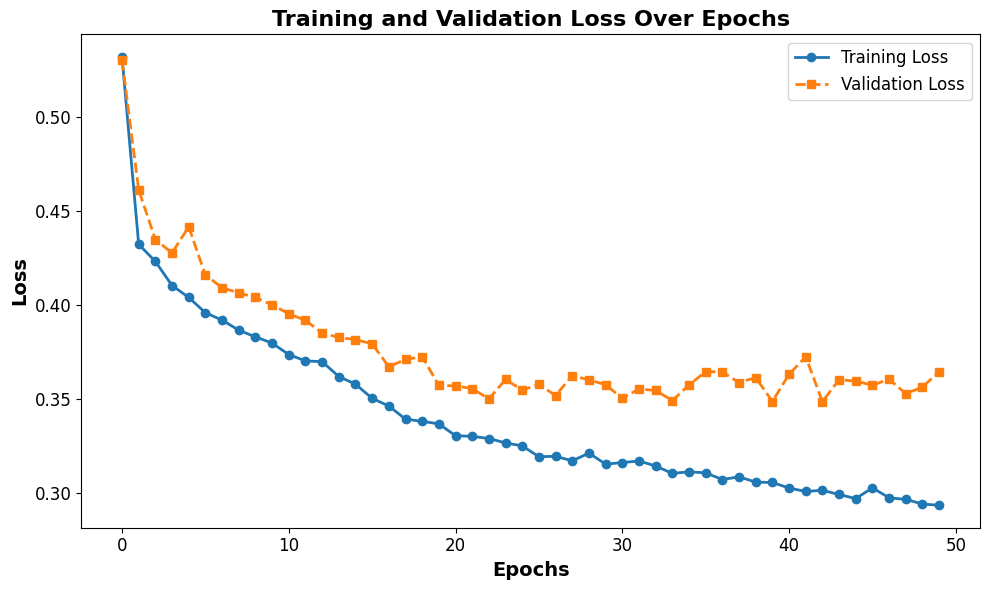

In [ ]:

import matplotlib.pyplot as plt

def plot_losses(train_losses, validation_losses):
    # Convert validation_losses to CPU and detach before plotting
    validation_losses = [v.cpu().detach().numpy() for v in validation_losses]

    # Set the figure size and style
    plt.figure(figsize=(10, 6))

    # Plot training loss with markers
    plt.plot(train_losses, label='Training Loss', color='tab:blue', marker='o', markersize=6, linestyle='-', linewidth=2)

    # Plot validation loss with markers and different style
    plt.plot(validation_losses, label='Validation Loss', color='tab:orange', marker='s', markersize=6, linestyle='--', linewidth=2)

    # Add labels, title, and legend with improved styles
    plt.xlabel('Epochs', fontsize=14, fontweight='bold')
    plt.ylabel('Loss', fontsize=14, fontweight='bold')
    plt.title('Training and Validation Loss Over Epochs', fontsize=16, fontweight='bold')

    # Display the legend with adjusted positioning
    plt.legend(loc='upper right', fontsize=12)

    # Adjust x and y ticks for better readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_losses(train_losses, val_losses)

In [ ]:
# Evaluation loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for ts_values, ts_indicators, ts_time, static, labels in val_loader:
        ts_values,ts_indicators,ts_time, static, labels = ts_values.to(device), ts_indicators.to(device),ts_time.to(device), static.to(device), labels.to(device)
        outputs = model(ts_values, ts_indicators,ts_time, static)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.long()).sum().item()

    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

Validation Accuracy: 84.57%


In [ ]:
def evaluate_model(model, data_loader, device):
    """
    Evaluates the model on the given data loader and calculates evaluation metrics.

    Args:
        model (torch.nn.Module): Trained model.
        data_loader (torch.utils.data.DataLoader): Data loader for validation/test set.
        device (torch.device): Device to perform computation on (CPU/GPU).

    Returns:
        dict: A dictionary containing evaluation metrics.
    """
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []
    y_prob = []

    with torch.no_grad():
        for ts_values, ts_indicators, ts_time, static, labels in data_loader:
            # Move data to device
            ts_values,ts_indicators, ts_time, static, labels = ts_values.to(device), ts_indicators.to(device), ts_time.to(device), static.to(device), labels.to(device)

            # Get model predictions
            outputs = model(ts_values, ts_indicators, ts_time, static)  # Raw logits
            probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Probability for class 1
            predictions = torch.argmax(outputs, dim=1)  # Predicted class labels

            # Collect predictions and ground truth
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            y_prob.extend(probabilities.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    roc_auc = roc_auc_score(y_true, y_prob)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc,
    }

In [ ]:
# Evaluate on the validation or test set
metrics = evaluate_model(model, val_loader, device)

# Print metrics
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 0.9916
Precision: 0.9612
Recall: 0.9791
F1-Score: 0.9701
ROC-AUC: 0.9992
